In [10]:
%pylab inline

import scipy.stats as stat
import sklearn.linear_model as lm
import scipy.optimize as opt
import pandas as pd
from scipy.ndimage.interpolation import shift

rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [29]:
import pandas_datareader.data as web
df = web.DataReader('^GSPC', 'yahoo', '2000-11-25', '2019-11-25').Close
#df = web.DataReader('SPY', 'stooq').Close.iloc[::-1]

In [30]:
LnR = np.log(df/df.shift(1))
LnR_normed = (LnR - LnR.mean()).iloc[1:]
vol = np.sqrt((LnR_normed**2).mean())

In [64]:
def build_cdf(X,n=500):
    cdfx = np.linspace(X.min(),X.max(),n)
    f_cdf = np.vectorize(lambda x: len(X[X < x])/len(X))
    cdf_inv = np.vectorize(lambda p: cdfx[len(cdfy[cdfy<=p])-1])
    return f_cdf,cdfx,f_cdf(cdfx),cdf_inv

In [149]:
f_cdf,cdfx,cdfy,cdf_inv = build_cdf(LnR_normed,n=200)

In [150]:
norm_equiv = stat.norm.cdf(cdfx,loc=0,scale=vol)

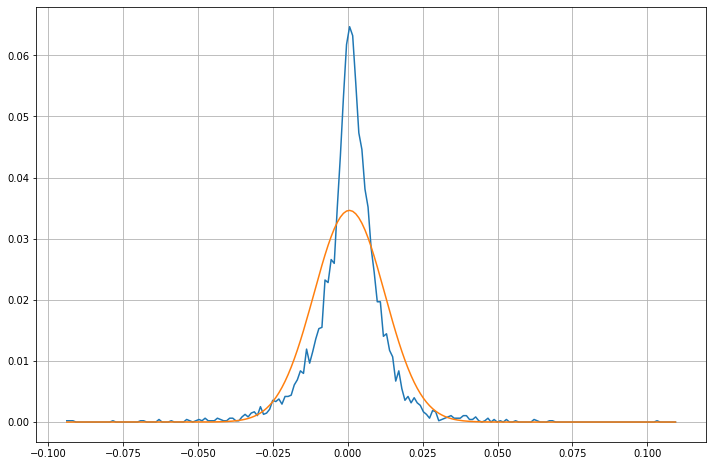

In [151]:
plot(cdfx[1:],np.diff(cdfy))
plot(cdfx[1:],np.diff(norm_equiv))

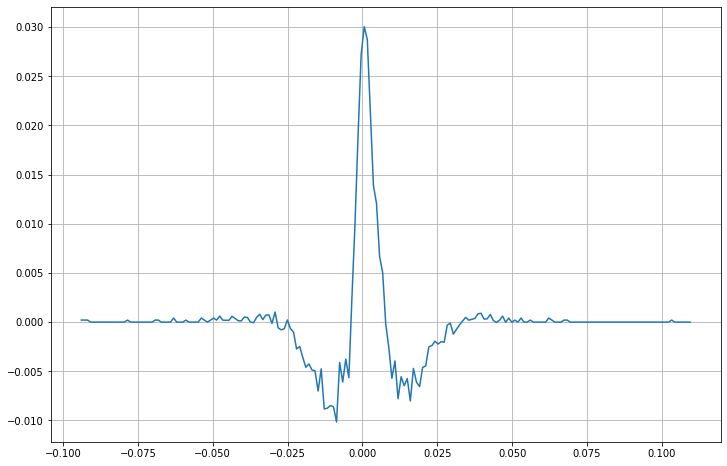

In [152]:
plot(cdfx[1:],np.diff(cdfy)-np.diff(norm_equiv))

In [153]:
solver = np.vectorize(lambda i: opt.brentq(lambda v: cdfy[i]-stat.norm.cdf(cdfx[i],scale=v),0.00001,1000.0))

In [154]:
solved_vols = solver(np.arange(len(cdfy)))

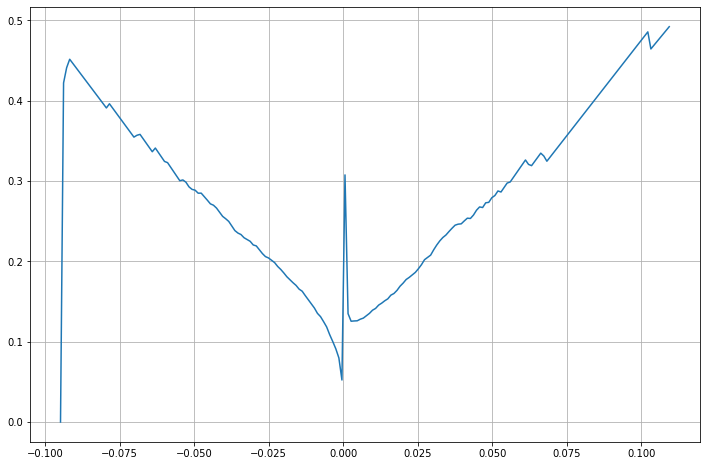

In [155]:
plot(cdfx,solved_vols*np.sqrt(252))

In [156]:
def CDFgen(num_paths,num_steps):
    rands = np.random.uniform(size=(num_paths,num_steps))
    return np.exp(cdf_inv(rands).cumsum(axis=1))

In [157]:
rands = np.random.uniform(size=(100000,1))
vals = cdf_inv(rands)
vals.mean()

-0.0005236137427895463

In [164]:
paths = CDFgen(100000,252)

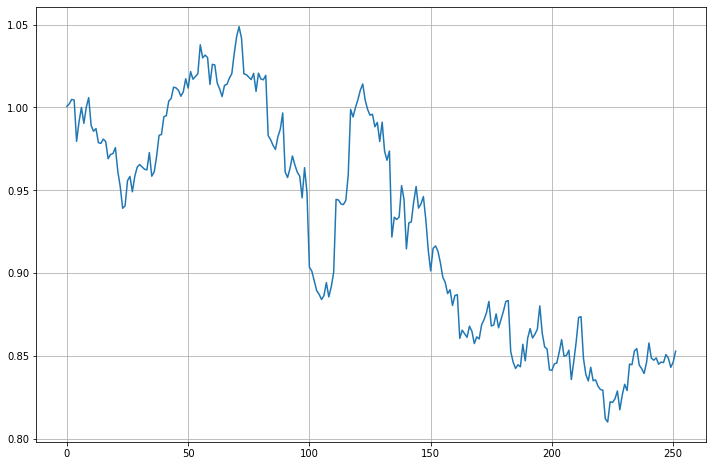

In [159]:
plot(paths[0])

In [160]:
paths[:,-1].mean()

0.8952006021854438

In [161]:
sim_vol = np.sqrt((np.log(paths[:,1:]/paths[:,:-1])**2).mean())
sim_vol*np.sqrt(252)

0.18701739674482268

In [162]:
def GBM(sigma,num_paths,num_steps):
    return (1+sigma*np.random.normal(size=(num_paths,num_steps))).cumprod(axis=1)

In [163]:
gbmpaths = GBM(sim_vol,100000,252)

In [145]:
numpy.maximum(gbmpaths[:,-1]-1.0,np.zeros(len(gbmpaths))).mean()

0.07465150929659212

In [146]:
numpy.maximum(paths[:,-1]-1.0,np.zeros(len(paths))).mean()

0.04583815788822341